In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Load Dataset
file_path = "data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Define the formula to calculate the target variable
data['Future_Retirement_Fund_Value'] = (
    data['Total_Invested_Amount'] * 
    (1 + data['Expected_ROI']) ** (data['Retirement_Age'] - data['Age'])
)

# Handle missing values
data.fillna({
    'Total_Invested_Amount': data['Total_Invested_Amount'].median(),
    'Expected_ROI': data['Expected_ROI'].mean(),
    'Savings_Rate': data['Savings_Rate'].median(),
    'Retirement_Age': 65,
    'Inflation_Rate': data['Inflation_Rate'].mean(),
    'Age': data['Age'].median()
}, inplace=True)

# Remove logical inconsistencies
data = data[data['Retirement_Age'] > data['Age']]

# Features and target
X = data[['Total_Invested_Amount', 'Expected_ROI', 'Savings_Rate', 'Retirement_Age', 'Inflation_Rate', 'Age']]
y = data['Future_Retirement_Fund_Value']

# Check for NaN or infinite values in y
if np.any(np.isnan(y)) or np.any(np.isinf(y)):
    print("Found invalid values in the target variable. Cleaning data...")

# Remove rows with invalid y values
valid_indices = ~np.isnan(y) & ~np.isinf(y)
X = X[valid_indices]
y = y[valid_indices]

# Check for extremely large values and cap them
max_y_value = 1e7  # Example: Cap at 10 million, adjust as needed
y = np.clip(y, a_min=None, a_max=max_y_value)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Model
model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42, min_samples_split=5, min_samples_leaf=3
)
model.fit(X_train_scaled, y_train)

# Evaluate Model
y_pred = model.predict(X_test_scaled)
print("Model trained successfully!")


Found invalid values in the target variable. Cleaning data...
Model trained successfully!


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Dataset
file_path = "data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Total_Invested_Amount'].fillna(data['Total_Invested_Amount'].median(), inplace=True)
data['Expected_ROI'].fillna(0.05, inplace=True)  # Assuming 5% ROI as default
data['Retirement_Age'].fillna(65, inplace=True)
data['Savings_Rate'].fillna(data['Savings_Rate'].median(), inplace=True)
data['Inflation_Rate'].fillna(3.0, inplace=True)  # Assuming 3% inflation rate

# Step 2: Outlier Capping
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

data = cap_outliers(data, 'Total_Invested_Amount')
data = cap_outliers(data, 'Savings_Rate')
data = cap_outliers(data, 'Expected_ROI')

# Step 3: Logical Consistency
data = data[data['Retirement_Age'] > data['Age']]  # Ensure retirement age > current age

# Step 4: Feature Engineering
data['Years_to_Retirement'] = data['Retirement_Age'] - data['Age']
data['Annual_Investment_Growth'] = data['Total_Invested_Amount'] * data['Expected_ROI']

# Fix for extreme ROI and years to retirement
data['Expected_ROI'] = np.clip(data['Expected_ROI'], a_min=0, a_max=0.2)  # Cap ROI at 20%
data['Years_to_Retirement'] = np.clip(data['Years_to_Retirement'], a_min=0, a_max=50)  # Cap at 50 years

# Log transform the target to stabilize exponential growth
data['Future_Retirement_Fund_Value'] = data['Total_Invested_Amount'] * np.power(
    (1 + data['Expected_ROI']), data['Years_to_Retirement']
)
data['Future_Retirement_Fund_Value'] = np.log1p(data['Future_Retirement_Fund_Value'])

# Define features and target
features = [
    'Age', 'Total_Invested_Amount', 'Expected_ROI', 'Savings_Rate', 
    'Inflation_Rate', 'Years_to_Retirement', 'Annual_Investment_Growth'
]
target = 'Future_Retirement_Fund_Value'

X = data[features]
y = data[target]

# Remove invalid values in y
valid_indices = ~np.isnan(y) & ~np.isinf(y)
X = X[valid_indices]
y = y[valid_indices]

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train Model
model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42, min_samples_split=5, min_samples_leaf=3
)
model.fit(X_train_scaled, y_train)

# Step 8: Evaluate Model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Save the model for later use (optional)
joblib.dump(model, 'retirement_fund_predictor.pkl')

# Predict on new data (example)
new_data = pd.DataFrame({
    'Age': [30],
    'Total_Invested_Amount': [5000],
    'Expected_ROI': [0.05],
    'Savings_Rate': [0.15],
    'Inflation_Rate': [3.0],
    'Years_to_Retirement': [35],
    'Annual_Investment_Growth': [2500]
})
new_data_scaled = scaler.transform(new_data)
future_value_log = model.predict(new_data_scaled)
future_value = np.expm1(future_value_log)
print(f"Predicted Future Retirement Fund Value: {future_value[0]:.2f}")


C:\Users\HP\AppData\Local\Temp\ipykernel_21184\1623815463.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_21184\1623815463.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Mean Squared Error: 0.005104168301696087
R-squared Score: 0.9992284023316528
Predicted Future Retirement Fund Value: 2135095.78


C:\Users\HP\AppData\Local\Temp\ipykernel_21184\2717011184.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_21184\2717011184.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Mean Squared Error: 0.005104168301696087
R-squared Score: 0.9992284023316528
Training Mean Squared Error: 0.004500267546417568
Training R-squared Score: 0.9993208969334779
Test Mean Squared Error: 0.005104168301696087
Test R-squared Score: 0.9992284023316528


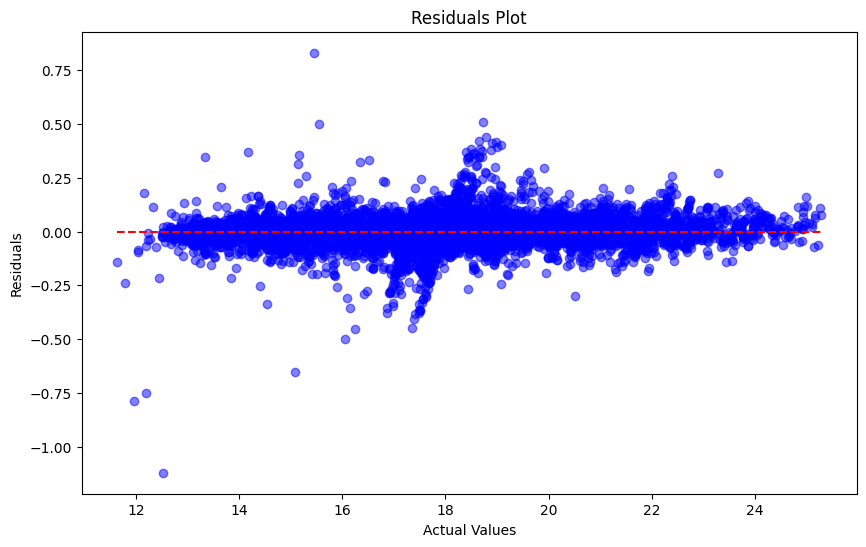

Predicted Future Retirement Fund Value: 2135095.78


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Load Dataset
file_path = "data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Total_Invested_Amount'].fillna(data['Total_Invested_Amount'].median(), inplace=True)
data['Expected_ROI'].fillna(0.05, inplace=True)  # Assuming 5% ROI as default
data['Retirement_Age'].fillna(65, inplace=True)
data['Savings_Rate'].fillna(data['Savings_Rate'].median(), inplace=True)
data['Inflation_Rate'].fillna(3.0, inplace=True)  # Assuming 3% inflation rate

# Step 2: Outlier Capping
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

data = cap_outliers(data, 'Total_Invested_Amount')
data = cap_outliers(data, 'Savings_Rate')
data = cap_outliers(data, 'Expected_ROI')

# Step 3: Logical Consistency
data = data[data['Retirement_Age'] > data['Age']]  # Ensure retirement age > current age

# Step 4: Feature Engineering
data['Years_to_Retirement'] = data['Retirement_Age'] - data['Age']
data['Annual_Investment_Growth'] = data['Total_Invested_Amount'] * data['Expected_ROI']

# Fix for extreme ROI and years to retirement
data['Expected_ROI'] = np.clip(data['Expected_ROI'], a_min=0, a_max=0.2)  # Cap ROI at 20%
data['Years_to_Retirement'] = np.clip(data['Years_to_Retirement'], a_min=0, a_max=50)  # Cap at 50 years

# Log transform the target to stabilize exponential growth
data['Future_Retirement_Fund_Value'] = data['Total_Invested_Amount'] * np.power(
    (1 + data['Expected_ROI']), data['Years_to_Retirement']
)
data['Future_Retirement_Fund_Value'] = np.log1p(data['Future_Retirement_Fund_Value'])

# Define features and target
features = [
    'Age', 'Total_Invested_Amount', 'Expected_ROI', 'Savings_Rate', 
    'Inflation_Rate', 'Years_to_Retirement', 'Annual_Investment_Growth'
]
target = 'Future_Retirement_Fund_Value'

X = data[features]
y = data[target]

# Remove invalid values in y
valid_indices = ~np.isnan(y) & ~np.isinf(y)
X = X[valid_indices]
y = y[valid_indices]

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train Model
model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42, min_samples_split=5, min_samples_leaf=3
)
model.fit(X_train_scaled, y_train)

# Step 8: Evaluate Model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Save the model for later use (optional)
joblib.dump(model, 'retirement_fund_predictor.pkl')

# 1. Evaluate on Training and Test Sets (Comparison)
y_train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {train_mse}")
print(f"Training R-squared Score: {train_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test R-squared Score: {test_r2}")

# 4. Residual Analysis - Plot residuals for the test set
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='red', linestyles='--')
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

# Predict on new data (example)
new_data = pd.DataFrame({
    'Age': [30],
    'Total_Invested_Amount': [5000],
    'Expected_ROI': [0.05],
    'Savings_Rate': [0.15],
    'Inflation_Rate': [3.0],
    'Years_to_Retirement': [35],
    'Annual_Investment_Growth': [2500]
})
new_data_scaled = scaler.transform(new_data)
future_value_log = model.predict(new_data_scaled)
future_value = np.expm1(future_value_log)
print(f"Predicted Future Retirement Fund Value: {future_value[0]:.2f}")


C:\Users\HP\AppData\Local\Temp\ipykernel_21184\2429158047.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_21184\2429158047.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Mean Squared Error: 0.005104168301696087
R-squared Score: 0.9992284023316528
Cross-validation R² scores: [0.99904915 0.9991647  0.9991998  0.99877971 0.99904704]
Mean Cross-validation R²: 0.999048080872145


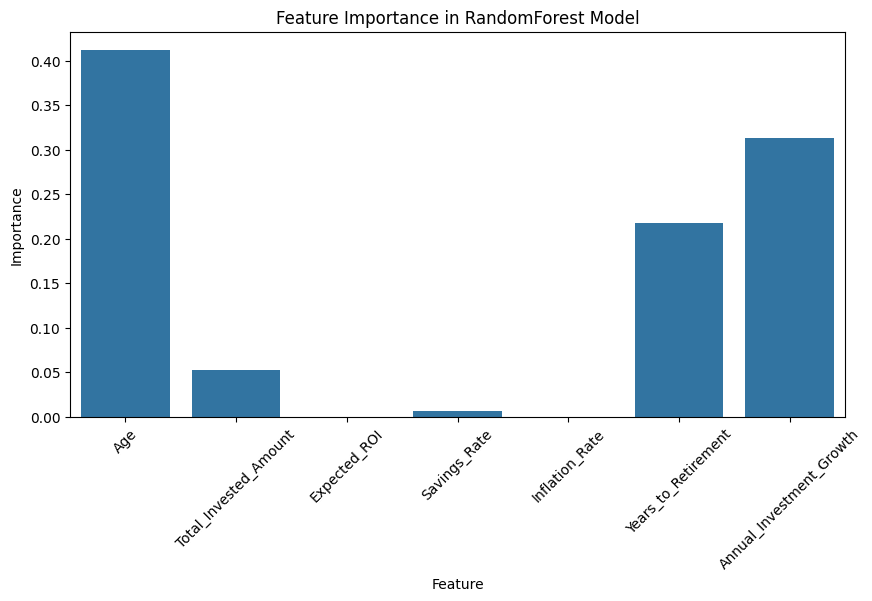

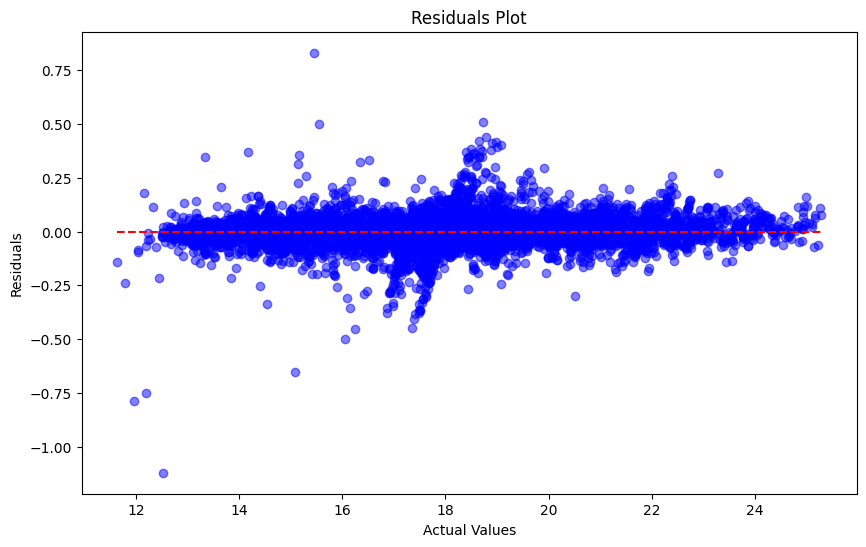

Predicted Future Retirement Fund Value: 2135095.78


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
file_path = "data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Total_Invested_Amount'].fillna(data['Total_Invested_Amount'].median(), inplace=True)
data['Expected_ROI'].fillna(0.05, inplace=True)  # Assuming 5% ROI as default
data['Retirement_Age'].fillna(65, inplace=True)
data['Savings_Rate'].fillna(data['Savings_Rate'].median(), inplace=True)
data['Inflation_Rate'].fillna(3.0, inplace=True)  # Assuming 3% inflation rate

# Step 2: Outlier Capping
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

data = cap_outliers(data, 'Total_Invested_Amount')
data = cap_outliers(data, 'Savings_Rate')
data = cap_outliers(data, 'Expected_ROI')

# Step 3: Logical Consistency
data = data[data['Retirement_Age'] > data['Age']]  # Ensure retirement age > current age

# Step 4: Feature Engineering
data['Years_to_Retirement'] = data['Retirement_Age'] - data['Age']
data['Annual_Investment_Growth'] = data['Total_Invested_Amount'] * data['Expected_ROI']

data['Expected_ROI'] = np.clip(data['Expected_ROI'], a_min=0, a_max=0.2)
data['Years_to_Retirement'] = np.clip(data['Years_to_Retirement'], a_min=0, a_max=50)

data['Future_Retirement_Fund_Value'] = data['Total_Invested_Amount'] * np.power(
    (1 + data['Expected_ROI']), data['Years_to_Retirement']
)
data['Future_Retirement_Fund_Value'] = np.log1p(data['Future_Retirement_Fund_Value'])

# Define features and target
features = [
    'Age', 'Total_Invested_Amount', 'Expected_ROI', 'Savings_Rate', 
    'Inflation_Rate', 'Years_to_Retirement', 'Annual_Investment_Growth'
]
target = 'Future_Retirement_Fund_Value'

X = data[features]
y = data[target]

valid_indices = ~np.isnan(y) & ~np.isinf(y)
X = X[valid_indices]
y = y[valid_indices]

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train Model
model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42, min_samples_split=5, min_samples_leaf=3
)
model.fit(X_train_scaled, y_train)

# Step 8: Evaluate Model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Save the model
joblib.dump(model, 'retirement_fund_predictor.pkl')

# Step 9: Cross-Validation to Check Overfitting
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean Cross-validation R²: {np.mean(cv_scores)}")

# Step 10: Feature Importance Analysis
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 5))
sns.barplot(x=features, y=feature_importances)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in RandomForest Model")
plt.xticks(rotation=45)
plt.show()

# Step 11: Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='red', linestyles='--')
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

# Predict on new data
new_data = pd.DataFrame({
    'Age': [30],
    'Total_Invested_Amount': [5000],
    'Expected_ROI': [0.05],
    'Savings_Rate': [0.15],
    'Inflation_Rate': [3.0],
    'Years_to_Retirement': [35],
    'Annual_Investment_Growth': [2500]
})
new_data_scaled = scaler.transform(new_data)
future_value_log = model.predict(new_data_scaled)
future_value = np.expm1(future_value_log)
print(f"Predicted Future Retirement Fund Value: {future_value[0]:.2f}")
